<a href="https://colab.research.google.com/github/jofmorenore/Spatial_Clustering/blob/main/CanadianWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip install rpy2==3.5.1

In [2]:
%load_ext rpy2.ipython

# Librerías

In [3]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}

In [4]:
%%R
if("fda" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("fda"))}

In [5]:
%%R
if("geofd" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geofd"))}

In [6]:
%%R
if("maps" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("maps"))}

In [ ]:
%%R
library(sf)
library(fda)
library(geofd)
library(maps)
library(dplyr)
library(ggplot2)

# Datos CanadianWeather

In [8]:
%%R
data(CanadianWeather, package="fda")
str(CanadianWeather, max.level = 1)

List of 8
 $ dailyAv      : num [1:365, 1:35, 1:3] -3.6 -3.1 -3.4 -4.4 -2.9 -4.5 -5.5 -3.1 -4 -5 ...
  ..- attr(*, "dimnames")=List of 3
 $ place        : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ province     : Named chr [1:35] "Newfoundland" "Nova Scotia" "Nova Scotia" "Nova Scotia" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ coordinates  : num [1:35, 1:2] 47.3 44.4 46.1 43.5 42.5 ...
  ..- attr(*, "dimnames")=List of 2
 $ region       : Named chr [1:35] "Atlantic" "Atlantic" "Atlantic" "Atlantic" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ monthlyTemp  : num [1:12, 1:35] -4.65 -5.33 -2.53 1.26 5.79 ...
  ..- attr(*, "dimnames")=List of 2
 $ monthlyPrecip: num [1:12, 1:35] 4.65 4.74 4.24 3.62 3.25 ...
  ..- attr(*, "dimnames")=List of 2
 $ geogindex    : Named num [1:35] 24 9 25 34 4 8 22 1 2 19 ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...


In [9]:
%%R
CanadianWeather$coordinates[,2]=-CanadianWeather$coordinates[,2]
head(CanadianWeather$coordinates)

            N.latitude W.longitude
St. Johns        47.34      -52.43
Halifax          44.39      -63.36
Sydney           46.09      -60.11
Yarmouth         43.50      -66.07
Charlottvl       42.48      -80.25
Fredericton      45.58      -66.39


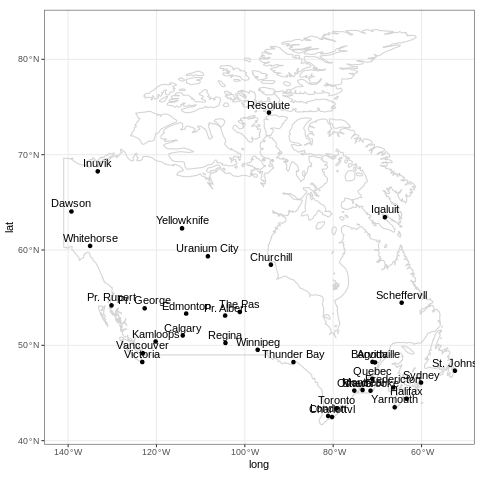

In [10]:
%%R
canada <- map("world", "Canada", fill = TRUE, plot = FALSE)
# Graficar los bordes de Canadá
ggplot() +
  geom_polygon(data = canada, aes(x = long, y = lat, group = group), color = "lightgray", fill = NA) +
  geom_sf(data = as.data.frame(CanadianWeather$coordinates) %>% st_as_sf(coords=c("W.longitude", "N.latitude"), crs =4326), col = 'black') +
  geom_text(aes(x = CanadianWeather$coordinates[,2], y = CanadianWeather$coordinates[,1], label = CanadianWeather$place), vjust = -0.5) +
  theme_bw()

# Base de Fourier con 65 funciones

[1] "done"


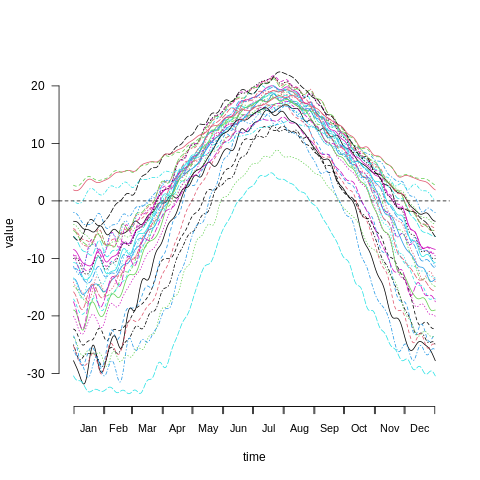

In [11]:
%%R
daybasis65 <- create.fourier.basis(rangeval=c(0, 365), nbasis=65, period = 365,
                                   axes=list('axesIntervals'))
Temp.fd <- with(CanadianWeather, smooth.basisPar(day.5,
                                                 dailyAv[,,'Temperature.C'], daybasis65)$fd)

plot(Temp.fd)

# Convertir a coordenadas planas

We employ the universal transverse mercator (UTM) coordinate system, which allows to compute the distance between two points on the Earth's surface by means of the Euclidean distance instead of the geodesic distance.

In [12]:
%%R
convertlatlong2UTM <- function(area, units = 'm') {
  # temporary sf conversion
  area <- sf::st_as_sf(area)
  bounds <- sf::st_bbox(area)
  lat = mean(bounds[c(2, 4)]) # latitude
  long = mean(bounds[c(1, 3)]) # longitude
  # find UTM hemisphere (latitude)
  hemisphere <- ifelse(lat > 0, "north", "south")
  # find UTM zone
  zone <- (floor((long + 180) / 6) %% 60) + 1
  crs <- paste0("+proj=utm +zone=", zone, " +datum=WGS84 +ellps=WGS84 +", hemisphere,
                " +units=", units, " +no_defs")
  return(crs)
}

In [13]:
%%R
CanadianWeather_planar = matrix(NA, nr=nrow(CanadianWeather$coordinates), nc=2)

for(i in 1:nrow(CanadianWeather$coordinates)){
    CanadianWeather_planar[i,] = as.data.frame(CanadianWeather$coordinates)[i,] %>%
                                  st_as_sf(.,coords=c("W.longitude", "N.latitude"), crs = 4326) %>%
                                  st_transform(crs = convertlatlong2UTM(.)) %>%
                                  st_coordinates()}

CanadianWeather_planar = as.data.frame(CanadianWeather_planar) %>% `colnames<-`(c("W.longitude", "N.latitude"))
head(CanadianWeather_planar)

  W.longitude N.latitude
1    391975.9    5243940
2    471327.0    4915254
3    723412.8    5108108
4    736879.4    4820512
5    561644.4    4703345
6    703620.6    5050698


# Functional regression model

In [14]:
%%R
TempRgn.f <- fRegress(Temp.fd ~ W.longitude + N.latitude, CanadianWeather_planar)
fdobj.res = TempRgn.f$yfdobj-TempRgn.f$yhatfdobj
summary(TempRgn.f)


Log10 Eigenvalues range from
 -1.74853310958279  to  15.0753732089503 
               Length Class  Mode   
yfdobj             3  fd     list   
xfdlist            3  -none- list   
betalist           3  -none- list   
betaestlist        3  -none- list   
yhatfdobj          3  fd     list   
Cmat           38025  -none- numeric
Dmat             195  -none- numeric
Cmatinv        38025  -none- numeric
wt                35  -none- numeric
df                 1  -none- logical
y2cMap             0  -none- NULL   
SigmaE             0  -none- NULL   
betastderrlist     0  -none- NULL   
bvar               0  -none- NULL   
c2bMap             0  -none- NULL   


# `okfd`: Semi-variograma empírico con coordenadas planas

In [ ]:
%%R
coord.cero <- matrix(c(-64.06, 45.79),nrow=1,ncol=2) %>% as.data.frame() %>%
              `colnames<-`(c('x', 'y')) %>% st_as_sf(coords = c('x', 'y'), crs = 4326) %>%
               st_transform(crs = convertlatlong2UTM(.)) %>% st_coordinates()

okfd.res <- okfd(new.coords=coord.cero, coords=CanadianWeather_planar,
                 data=CanadianWeather$dailyAv[,,'Temperature.C'],
                 smooth.type='fourier', nbasis=65, argvals=day.5,
                 fix.nugget=TRUE, nugget=0, kappa=0.7)

+ `CanadianWeather_planar`:
Error in solve.default(leftmatrix, rightmatrix) :
  system is computationally singular: reciprocal condition number = 2.36899e-19:

# `okfd`: Semi-variograma empírico con coordenadas en grados

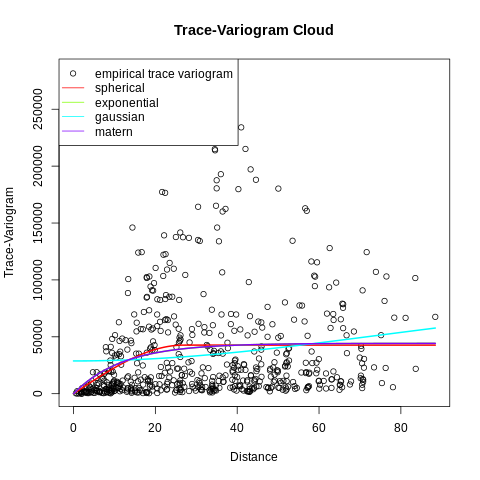

In [16]:
%%R
coord.cero <- matrix(c(-64.06, 45.79),nrow=1,ncol=2)
okfd.res2 <- okfd(new.coords=coord.cero, coords=CanadianWeather$coordinates,
                  data=CanadianWeather$dailyAv[,,'Temperature.C'],
                  smooth.type='fourier', nbasis=65, argvals=day.5,
                  fix.nugget=FALSE, nugget=0, fix.kappa=TRUE)
plot(okfd.res2)

# `trace.variog`

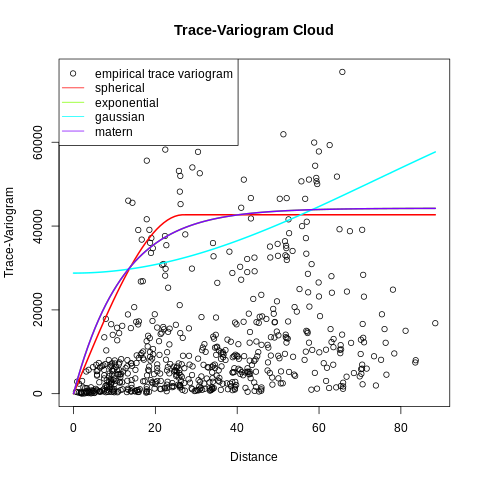

In [17]:
%%R
M <- fourierpen(fdobj.res$basis,  Lfdobj=0)
L2norm = l2.norm(ncol(fdobj.res$coefs), fdobj.res, M)

new.emp.trace.vari1 <- trace.variog(coords=CanadianWeather$coordinates,
                                   L2norm=L2norm, bin=FALSE)

#okfd.res2$trace.vari <- new.emp.trace.vari1
okfd.res2$emp.trace.vari <- new.emp.trace.vari1
plot(okfd.res2)

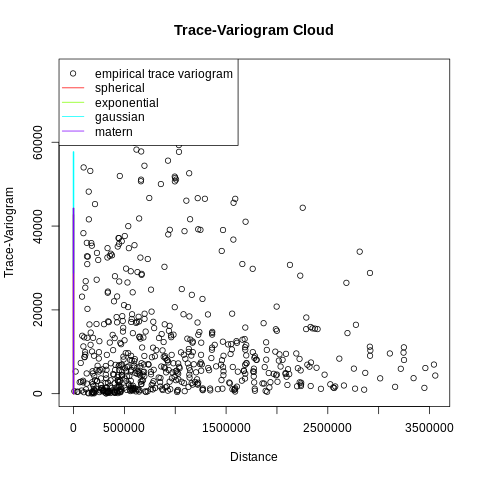

In [18]:
%%R
new.emp.trace.vari2 <- trace.variog(coords=CanadianWeather_planar,
                                    L2norm=L2norm, bin=FALSE)

#okfd.res2$trace.vari <- new.emp.trace.vari2
okfd.res2$emp.trace.vari <- new.emp.trace.vari2
plot(okfd.res2)

# `fit.tracevariog`

In [19]:
%%R
fit1 = geofd::fit.tracevariog(new.emp.trace.vari1, models = "spherical",
                              sigma2.0 = 7750, phi.0 = 2200,
                              fix.nugget=TRUE, nugget=0, fix.kappa=FALSE,
                              max.dist.variogram=NULL)
fit1$best$cov.pars

[1] 18344.71633    62.30389


In [20]:
%%R
fit1$best

$nugget
[1] 0

$cov.pars
[1] 18344.71633    62.30389

$cov.model
[1] "spherical"

$kappa
[1] 1

$value
[1] 100806517207

$trend
NULL

$beta.ols
NULL

$practicalRange
[1] 62.30389

$max.dist
[1] 88.41155

$minimisation.function
[1] "optim"

$weights
[1] "equal"

$method
[1] "OLS"

$fix.nugget
[1] TRUE

$fix.kappa
[1] FALSE

$message
[1] "optim convergence code: 0"

$call
.variofit(vario = emp.trace.vari, ini.cov.pars = c(sigma2.0, 
    phi.0), cov.model = models[cont], fix.nugget = fix.nugget, 
    nugget = nugget, fix.kappa = fix.kappa, kappa = kappa, max.dist = max.dist.variogram, 
    messages = FALSE)

attr(,"class")
[1] "variomodel" "variofit"  


In [21]:
%%R
fit2 = geofd::fit.tracevariog(new.emp.trace.vari2, models = "spherical",
                              sigma2.0 = 7750, phi.0 = 2200,
                              fix.nugget=TRUE, nugget=0, fix.kappa=FALSE,
                              max.dist.variogram=NULL)
fit2$best$cov.pars

[1] 11659.74  2200.00


In [22]:
%%R
fit2$best

$nugget
[1] 0

$cov.pars
[1] 11659.74  2200.00

$cov.model
[1] "spherical"

$kappa
[1] 1

$value
[1] 114405887769

$trend
NULL

$beta.ols
NULL

$practicalRange
[1] 2200

$max.dist
[1] 3556668

$minimisation.function
[1] "optim"

$weights
[1] "equal"

$method
[1] "OLS"

$fix.nugget
[1] TRUE

$fix.kappa
[1] FALSE

$message
[1] "optim convergence code: 0"

$call
.variofit(vario = emp.trace.vari, ini.cov.pars = c(sigma2.0, 
    phi.0), cov.model = models[cont], fix.nugget = fix.nugget, 
    nugget = nugget, fix.kappa = fix.kappa, kappa = kappa, max.dist = max.dist.variogram, 
    messages = FALSE)

attr(,"class")
[1] "variomodel" "variofit"  


In [23]:
%%R
sigma2 = c(seq(7497, length.out = 30, by=17))
phi    = c(seq(1960, length.out = 30, by=14))

In [24]:
%%R
par_estimate = data.frame(list("sigma2_ini"=NA, "phi_ini"=NA, "partial sill"=NA, "range"=NA))
k=1

for(i in 1:30){
    for(j in 1:30){
        fit1 = geofd::fit.tracevariog(new.emp.trace.vari1, models = "spherical",
                                      sigma2.0 = sigma2[i], phi.0 = phi[j],
                                      fix.nugget=FALSE, nugget=0, fix.kappa=FALSE,
                                      max.dist.variogram=NULL)
        par_estimate[k,]= c(sigma2[i], phi[j], fit1$best$cov.pars)
        k = k+1
    }
}

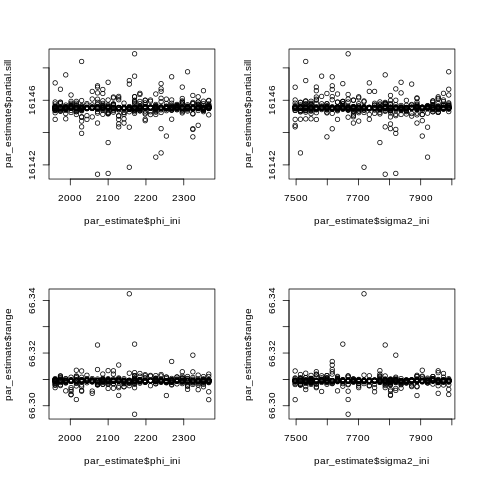

In [25]:
%%R
par(mfrow=c(2,2))
# sin importar los valores iniciales de sigma2 y phi la sill estimada es
plot(par_estimate$phi_ini, par_estimate$partial.sill)
plot(par_estimate$sigma2_ini, par_estimate$partial.sill)
# para algunas combinaciones es cero, y para otras combinaciones converge a
plot(par_estimate$phi_ini, par_estimate$range)
plot(par_estimate$sigma2_ini, par_estimate$range)

In [26]:
%%R
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] splines   tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.4.2   dplyr_1.1.2     maps_3.4.1      geofd_2.0      
 [5] fda_6.1.4       deSolve_1.35    fds_1.8         RCurl_1.98-1.12
 [9] rainbow_3.7  